<div class="well well-lg"><h1>Comparison of modified methods to calculate sea level contributions on global grid</h1></div>

This notebook calulates sea-level contributions from an extended ISMIP6 projections, 
- using different methods (defined in slc) and for 
- different regions (global, southpolar ISMIP region, rest of the world and along coast lines)


contact: 
- Torsten Albrecht (torsten.albrecht@pik-potsdam.de) | Potsdam Institute for Climate Impact Research (PIK) and 
- Heio Goelzer (HEIG@norceresearch.no) | Norwegian Research Centre (NORCE), Affiliated Bjerknes Centre for Climate Research

<div class="alert alert-info">
CC-BY: Creative Commons Attribution 4.0 International  
</div>

In [1]:
import matplotlib.pylab as plt
from matplotlib import cm, colors
import netCDF4 as nc
import numpy as np
import os, glob

# SL methods
from slc import slc_vaf
from slc import slc_G2020_publ
from slc import slc_G2020
from slc import slc_A2020

# Get constants
from slc import sl_constants as c

# Plotting
from slc import plotting


In [2]:
# Parameters
#clat=-50 # -50°S
#clat=-55
clat=-59 
#clat=-60
#clat=-65


In [3]:
# Main data path
datapath = "/data/projects/ismip7sealevel/files"

In [4]:
# Relative reference frame for Vaf and G2020
def get_slc_estimates(H0,H,B0,B,S0,S,zn0,zn,A):

    slc_af = slc_vaf.get_slc_vaf_HBA(H0,H,B0,B,A)
    slc_a2020 = slc_A2020.get_slc_A2020(H0,H,B0,B,S0,S,A)
    slc_g2020 = slc_G2020.get_slc_G2020_publ(H0,H,B0,B,zn0,zn,A)
    slc_diff_ag  = slc_a2020-slc_g2020
    slc_diff_va  = slc_af-slc_a2020
    slc_diff_vg  = slc_af-slc_g2020

    print('sea level change due to VAF:\t\t\t',np.around(slc_af,decimals=4))
    print('sea level change due to A2020:\t\t\t',np.around(slc_a2020,decimals=4))
    print('sea level change due to G2020:\t\t\t',np.around(slc_g2020,decimals=4))
    print('difference vaf-a2020:\t\t\t',np.around(slc_diff_va,decimals=4))
    print('difference vaf-g2020:\t\t\t',np.around(slc_diff_vg,decimals=4))
    print('difference a2020-g2020:\t\t\t',np.around(slc_diff_ag,decimals=4))
    
    return (slc_af,slc_g2020,slc_a2020,slc_diff_ag,slc_diff_vg)


# Absolute reference frame for Vaf and G2020
def get_slc_estimates_abs(H0,H,B0,B,S0,S,A):

    slc_af = slc_vaf.get_slc_vaf(H0,H,B0,B,S0,S,A)
    slc_a2020 = slc_A2020.get_slc_A2020(H0,H,B0,B,S0,S,A)
    slc_g2020 = slc_G2020.get_slc_G2020(H0,H,B0,B,A)
    slc_diff_ag  = slc_a2020-slc_g2020
    slc_diff_vg  = slc_af-slc_g2020
    slc_diff_va  = slc_af-slc_a2020

    print('sea level change due to VAF:\t\t\t',np.around(slc_af,decimals=4))
    print('sea level change due to A2020:\t\t\t',np.around(slc_a2020,decimals=4))
    print('sea level change due to G2020:\t\t\t',np.around(slc_g2020,decimals=4))
    print('difference vaf-a2020:\t\t\t',np.around(slc_diff_va,decimals=4))
    print('difference vaf-g2020:\t\t\t',np.around(slc_diff_vg,decimals=4))
    print('difference a2020-g2020:\t\t\t',np.around(slc_diff_ag,decimals=4))
    
    return (slc_af,slc_g2020,slc_a2020,slc_diff_ag,slc_diff_vg,slc_diff_va)


### ISMIP6 2300 contribution by PIK_PISM coupled to VILMA
 
- reference and initial topography in the year 1850 has been optimized in 4 iterations to match present-day observations, coupling interval is 1 yr
- forcings is identical to PIK_PISM contribution in Seroussi et al., 2024
- here, we compare sea-level contributions in the year 2300 compared to 1850
- n256 is a global grid, ocean and ice mass should be conserved

In [5]:
# ISMIP6 2300 contribution by PIK_PISM

fref =datapath+"/ismip2300-coupled/pism_vilma_n256_1850.nc"
#
f0 =datapath+"/ismip2300-coupled/pism_vilma_n256_1850.nc"
#f0 =datapath+"/ismip2300-coupled/pism_vilma_n256_2000.nc"
#f0 =datapath+"/ismip2300-coupled/pism_vilma_n256_2100.nc"
#f0 =datapath+"/ismip2300-coupled/pism_vilma_n256_2200.nc"
#
#f =datapath+"/ismip2300-coupled/pism_vilma_n256_2200.nc"
f =datapath+"/ismip2300-coupled/pism_vilma_n256_2300.nc"

idat = nc.Dataset(fref, 'r')
topg_ref_PISM  = idat.variables["topg"][0,:]
rsl_ref_PISM  = idat.variables["rslc"][0,:]
flg_ref_PISM  = idat.variables["flg"][0,:]
idat.close()

idat = nc.Dataset(f0, 'r')
lithk0_PISM  = idat.variables["lithk"][0,:]
topg0_PISM  = idat.variables["topg"][0,:]
rsl0_PISM  = idat.variables["rslc"][0,:]
ur0_PISM  = idat.variables["ur"][0,:]
flg0_PISM  = idat.variables["flg"][0,:]
idat.close()
H0 = lithk0_PISM.copy()
B0 = topg_ref_PISM + ur0_PISM
S0 = B0 - topg0_PISM
Zn0 = -S0
R0 = rsl0_PISM.copy()
#O0 = flg0_PISM==1
O0 = (flg0_PISM==1) | (flg0_PISM==4)

idat = nc.Dataset(f, 'r')
lithk_PISM  = idat.variables["lithk"][0,:]
topg_PISM  = idat.variables["topg"][0,:]
rsl_PISM  = idat.variables["rslc"][0,:]
ur_PISM  = idat.variables["ur"][0,:]
flg_PISM  = idat.variables["flg"][0,:]
vlon1 = idat.variables["lon"][:] #1D
vlat1 = idat.variables["lat"][:] #1D
idat.close()
vlon, vlat = np.meshgrid(vlon1, vlat1, indexing='xy') #2d
# in PISM topg=topg_ref-rsl; to determine changes in B and S separately use ur
# B=topg_ref_PISM+ur_PISM; S=B-topg_PISM
H = lithk_PISM.copy()
B = topg_ref_PISM + ur_PISM
S = B - topg_PISM
Zn = -S
R = rsl_PISM.copy()
#O = flg_PISM==1
O = (flg_PISM==1) | (flg_PISM==4)

# coast mask 
lsm = (flg_ref_PISM==1)
#plotting.plot_global(lsm, vlon, vlat)

# Circular boundary conditions
bnd = np.zeros((1,1024))
bnd[:] = lsm[0,:]
lsm_ext1 = np.append(lsm, bnd, axis=0)
CM1 = np.diff(lsm_ext1,1,0)
bnd[:] = lsm[-1,:]
lsm_ext2 = np.append(bnd, lsm, axis=0)
CM2 = np.diff(lsm_ext2,1,0)
bnd = np.zeros((512,1))
bnd[:,0] = lsm[:,0]
lsm_ext3 = np.append(lsm, bnd, axis=1)
CM3 = np.diff(lsm_ext3,1,1)
bnd[:,0] = lsm[:,-1]
lsm_ext4 = np.append(bnd, lsm, axis=1)
CM4 = np.diff(lsm_ext4,1,1)
#plotting.plot_global(CM1, vlon, vlat)
LMS = np.abs(CM1) + np.abs(CM2) + np.abs(CM3) + np.abs(CM4)
LMS = (LMS>0)
#plotting.plot_global(LMS, vlon, vlat,'coastlines')


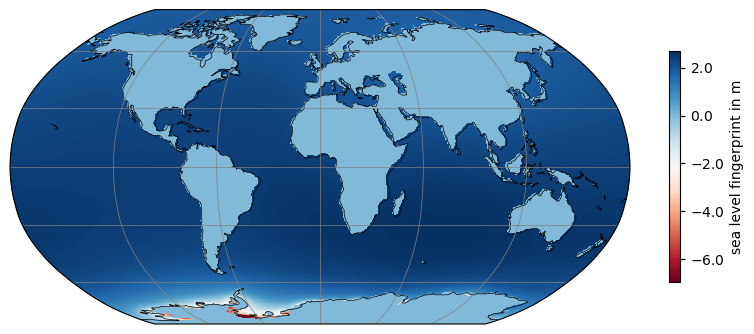

In [6]:
plotting.plot_global(S*O, vlon, vlat,'sea level fingerprint in m')

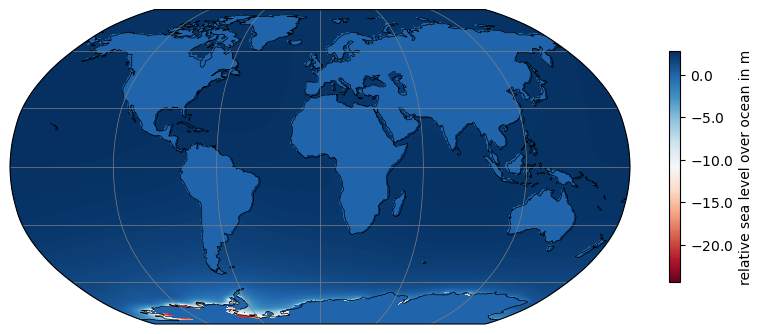

In [7]:
plotting.plot_global(R*O, vlon, vlat,'relative sea level over ocean in m')

In [8]:
# grid generic info

pdvfile = datapath+"/ismip2300-coupled/vilma_n256_cellarea_lonlat2d.nc"
tdat = nc.Dataset(pdvfile, 'r')
cav = tdat.variables["cell_area"][:] #2D
tdat.close()

A = cav

mfile = datapath+"/ismip2300-coupled/ISMIP6_mask_n256.nc"
tdat = nc.Dataset(mfile, 'r')
imask = tdat.variables["ISMIP6_mask"][:] #2D
tdat.close()
#print(np.shape(imask))
#print(np.shape(cav))

imask = imask.filled(0)
#plotting.plot_global(imask, vlon, vlat)

LMSA = np.sum(LMS*A)

print('Ocean area, without and with ice shelves in the 1850 data, and in constants')
print('AOv, AOSv, AO', np.sum(A*((flg_ref_PISM==1)))*1e-12, np.sum(A*((flg_ref_PISM==1) | (flg_ref_PISM==4)))*1e-12,c.AO*1e-12)


Ocean area, without and with ice shelves in the 1850 data, and in constants
AOv, AOSv, AO 361.1020479282973 362.8053640673055 362.5


In [9]:
## Compare methods global
print('# Global # ')
print('Earth surface:\t\t', np.round(np.sum(A)*1e-12),'million km2\n')
print('Vtot  :\t\t\t',np.around(slc_vaf.get_slc_vtot(H0,H,A),decimals=4),'m SLE')
print('Vgr  :\t\t\t',np.around(slc_vaf.get_slc_vgr(H0,H,B0,B,S0,S,A),decimals=4),'m SLE')
print('Vaf  :\t\t\t',np.around(slc_vaf.get_slc_vaf(H0,H,B0,B,S0,S,A),decimals=4),'m SLE\n')
print('A2020:\t\t\t',np.around(slc_A2020.get_slc_A2020(H0,H,B0,B,S0,S,A),decimals=4),'m SLE')
print('G2020:\t\t\t',np.around(slc_G2020.get_slc_G2020(H0,H,B0,B,A),decimals=4),'m SLE\n')

print('GMSL  :\t\t\t',np.around(slc_vaf.get_mean_diff(R0*O0,R*O,A,c.AO),decimals=4),'m SLE')
print('GMSL_abs  :\t\t',np.around(slc_vaf.get_mean_diff(S0*O0,S*O,A,c.AO),decimals=4),'m SLE')
print('CMSL  :\t\t\t',np.around(slc_vaf.get_mean_diff(R0,R,A*LMS,LMSA),decimals=4),'m SLE')

slc_g2020_glob = slc_G2020.get_slc_G2020(H0,H,B0,B,A)

# Global # 
Earth surface:		 510.0 million km2

Vtot  :			 5.3717 m SLE
Vgr  :			 4.7311 m SLE
Vaf  :			 2.1621 m SLE

A2020:			 2.2636 m SLE
G2020:			 2.2954 m SLE

GMSL  :			 2.2351 m SLE
GMSL_abs  :		 2.2671 m SLE
CMSL  :			 1.9826 m SLE


In [10]:
print("GMSL-GMSL_abs:",np.around(slc_vaf.get_mean_diff(R0*O0,R*O,A,c.AO)-slc_vaf.get_mean_diff(S0*O0,S*O,A,c.AO),decimals=4))
print("A2020-G2020:",np.around(slc_A2020.get_slc_A2020(H0,H,B0,B,S0,S,A)-slc_G2020.get_slc_G2020(H0,H,B0,B,A),decimals=4))

GMSL-GMSL_abs: -0.032
A2020-G2020: -0.0318


# ISMIP6 grid mask
ISMIP6 surface:		 35.9504 million km2

Vtot  :			 5.3717
Vgr  :			 4.7348
Vaf  :			 2.1604 

A2020:			 2.2636
G2020:			 2.358 

GMSL  :			 -0.0181
GMSL_abs  :		 0.0769
CMSL  :			 -3.0428


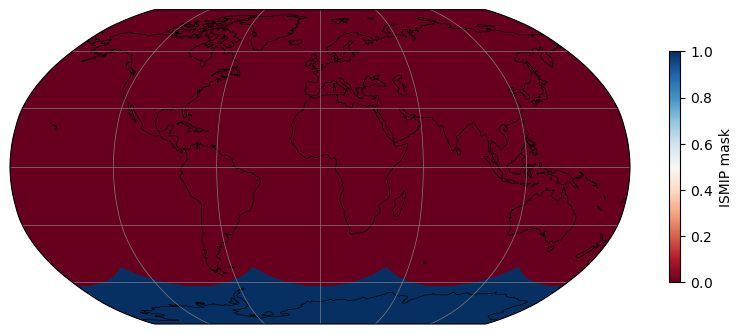

In [11]:
# PISM mask

amask = imask>0.5

H0 = lithk0_PISM.copy()
B0 = topg_ref_PISM + ur0_PISM
S0 = B0 - topg0_PISM
Zn0 = -S0
R0 = rsl0_PISM.copy()
#O0 = flg0_PISM==1
O0 = (flg0_PISM==1) | (flg0_PISM==4)
H = lithk_PISM.copy()
B = topg_ref_PISM + ur_PISM
S = B - topg_PISM
Zn = -S
R = rsl_PISM.copy()
#O = flg_PISM==1
O = (flg_PISM==1) | (flg_PISM==4)

H0 = H0[amask]
B0 = B0[amask]
S0 = S0[amask]
Zn0 = Zn0[amask]
R0 = R0[amask]
O0 = O0[amask]

H = H[amask]
B = B[amask]
S = S[amask]
Zn = Zn[amask]
R = R[amask]
O = O[amask]

A = cav[amask]

LMS_i = LMS[amask]
LMSA_i = np.sum(LMS_i*A)

print('# ISMIP6 grid mask')
print('ISMIP6 surface:\t\t', np.round(np.sum(A)*1e-12,decimals=4),'million km2\n')
print('Vtot  :\t\t\t',np.around(slc_vaf.get_slc_vtot(H0,H,A),decimals=4))
print('Vgr  :\t\t\t',np.around(slc_vaf.get_slc_vgr(H0,H,B0,B,S0,S,A),decimals=4))
print('Vaf  :\t\t\t',np.around(slc_vaf.get_slc_vaf(H0,H,B0,B,S0,S,A),decimals=4),'\n')
print('A2020:\t\t\t',np.around(slc_A2020.get_slc_A2020(H0,H,B0,B,S0,S,A),decimals=4))
print('G2020:\t\t\t',np.around(slc_G2020.get_slc_G2020(H0,H,B0,B,A),decimals=4),'\n')

print('GMSL  :\t\t\t',np.around(slc_vaf.get_mean_diff(R0*O0,R*O,A,c.AO),decimals=4))
print('GMSL_abs  :\t\t',np.around(slc_vaf.get_mean_diff(S0*O0,S*O,A,c.AO),decimals=4))
print('CMSL  :\t\t\t',np.around(slc_vaf.get_mean_diff(R0,R,A*LMS_i,LMSA_i),decimals=4))

plotting.plot_global((amask>0), vlon, vlat,'ISMIP mask')


In [12]:
print("G2020_glob-G2020_reg:",np.around(slc_g2020_glob-slc_G2020_abs.get_slc_G2020(H0,H,B0,B,A),decimals=4))

NameError: name 'slc_G2020_abs' is not defined

In [ ]:
# Rest of world

amask = imask<0.5

H0 = lithk0_PISM.copy()
B0 = topg_ref_PISM + ur0_PISM
S0 = B0 - topg0_PISM
Zn0 = -S0
R0 = rsl0_PISM.copy()
#O0 = flg0_PISM==1
O0 = (flg0_PISM==1) | (flg0_PISM==4)
H = lithk_PISM.copy()
B = topg_ref_PISM + ur_PISM
S = B - topg_PISM
Zn = -S
R = rsl_PISM.copy()
#O = flg_PISM==1
O = (flg_PISM==1) | (flg_PISM==4)


H0 = H0[amask]
B0 = B0[amask]
S0 = S0[amask]
Zn0 = Zn0[amask]
R0 = R0[amask]
O0 = O0[amask]

H = H[amask]
B = B[amask]
S = S[amask]
Zn = Zn[amask]
R = R[amask]
O = O[amask]

A = cav[amask]

LMS_i = LMS[amask]
LMSA_i = np.sum(LMS_i*A)


print('# Ouside PISM grid' )
print('Rest surface:\t\t', np.round(np.sum(A)*1e-12),'million km2\n')
print('Vtot  :\t\t\t',np.around(slc_vaf.get_slc_vtot(H0,H,A),decimals=4))
print('Vgr  :\t\t\t',np.around(slc_vaf.get_slc_vgr(H0,H,B0,B,S0,S,A),decimals=4))
print('Vaf  :\t\t\t',np.around(slc_vaf.get_slc_vaf(H0,H,B0,B,S0,S,A),decimals=4),'\n')
print('A2020:\t\t\t',np.around(slc_A2020.get_slc_A2020(H0,H,B0,B,S0,S,A),decimals=4))
print('G2020:\t\t\t',np.around(slc_G2020.get_slc_G2020(H0,H,B0,B,A),decimals=4),'\n')

print('GMSL  :\t\t\t',np.around(slc_vaf.get_mean_diff(R0*O0,R*O,A,c.AO),decimals=4))
print('GMSL_abs  :\t\t',np.around(slc_vaf.get_mean_diff(S0*O0,S*O,A,c.AO),decimals=4))
print('CMSL  :\t\t\t',np.around(slc_vaf.get_mean_diff(R0,R,A*LMS_i,LMSA_i),decimals=4))



In [ ]:
print("CMSL-GMSL:",np.around(slc_vaf.get_mean_diff(R0,R,A*LMS_i,LMSA_i)-slc_vaf.get_mean_diff(R0*O0,R*O,A,c.AO),decimals=4))